# Exploration

In his notebook, you have all the tools necessary to analyze a given graph, constructed from a dataset given as input. <br/>

## Table of contents
1. [Loading dataset](#Part-I:-Loading-dataset) 
2. [Graph properties](#Part-II:-Graph-properties) 
3. [Type of graph identification](#Part-III:-Type-of-graph-identification)
4. [Nodes properties](#Part-IV:-Node-properties)
5. [Attributes analysis](#Part-V:-Attributes-analysis)

## Part I: Loading dataset

We constructed our graph using Seealsology tool, and we chose to use the following Wikipedia pages as seeds for this purpose:
- [Machine learning](https://en.wikipedia.org/wiki/Machine_learning)
- [Natural language processing](https://en.wikipedia.org/wiki/Natural_language_processing)
- [Artificial intelligence](https://en.wikipedia.org/wiki/Artificial_intelligence)
- [Artifical neural network](https://en.wikipedia.org/wiki/Artificial_neural_network)
- [Chatbot](https://en.wikipedia.org/wiki/Chatbot)
- [Intelligent agent](https://en.wikipedia.org/wiki/Intelligent_agent)
- [Data visualization](https://en.wikipedia.org/wiki/Data_visualization)

In [71]:
# Standard librairies
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import operator
import collections
from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

In [3]:
# loading the tsv file that we generated from seealsology
df = pd.read_csv("ml-nlp-ai-ann-chatbot-ia-dataviz-dist2.tsv", sep = "\t")
df.head()

,source,target,depth
0,intelligent agent,software agent,1
1,intelligent agent,cognitive architecture,1
2,intelligent agent,cognitive radio,1
3,intelligent agent,cybernetics,1
4,intelligent agent,computer science,1


In [4]:
G = nx.from_pandas_edgelist(df, "source", "target", edge_attr=True, create_using=nx.Graph())

In [5]:
print("Our network has", len(G.nodes), "nodes and", len(G.edges), "edges.")

Our network has 1166 nodes and 1439 edges.


## Part II: Graph properties

### 1) connected components and diameter

In [6]:
# computation of the number of connected components of the graph
n_cc = nx.number_connected_components(G)
print("The graph has", n_cc, "connected component(s).")

The graph has 1 connected component(s).


In [8]:
# study of the giant component
giant_graph = max(nx.connected_component_subgraphs(G), key=len)
print("The giant component of the graph has", giant_graph.number_of_nodes(), "nodes and", giant_graph.size(), "edges.")

The giant component of the graph has 1166 nodes and 1439 edges.


We can observe that the giant component of our network is basically the whole graph itself.

In [14]:
# computation of the diameter of the graph
diam = nx.diameter(G)
print("The graph has a diameter of", diam, ".")

The graph has a diameter of 9 .


First important point is that the graph is connected, and that is essential for our product to have all the nodes that are linked to some others, otherwise we would never use some nodes of our graph. This also goes along with the idea that Wikipedia graphs form a ball. On the other hand, a diameter of 9 is pretty convenient, as we know that the graph is not too wide.

### 2) sparsity and degree distribution

In [15]:
# computation of adjacency matrix of our network
A = np.array(nx.adjacency_matrix(G).todense())

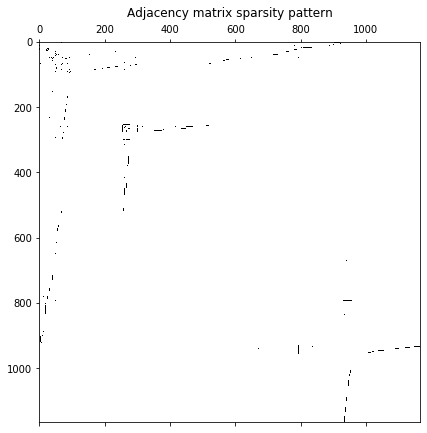

In [11]:
plt.figure(figsize=(10,7))
plt.title('Adjacency matrix sparsity pattern')
plt.spy(A)
plt.show()

As we can see, the adjacency matrix of our graph is very sparse, and that was expected regarding the number of edges our graph has.

In [24]:
# study of the moments of the degree distribution
degrees = np.sum(A, axis=0).reshape(-1)
print("The first moment of this graph is", np.mean(degrees))
print("The second moment of this graph is", np.mean(np.power(degrees,2)))

The first moment of this graph is 2.4682675814751285
The second moment of this graph is 30.941680960548887


The first moment does correspond to the mean of the degree distribution, here it has a value of roughly 2.5. The second moment gives us information about the variance of the degree distribution, and has here a value of roughly 31. 

One thing we can try is to remove the hubs from our graph, and see the effect on the adjacency matrix and on the degree distribution.

In [21]:
# removing 10 hubs from our network
sorted_A = np.argsort(np.sum(A,axis=0))[:-10]
reduced_A = A[sorted_A,:][:,sorted_A]
G_reduced = nx.from_numpy_matrix(reduced_A)

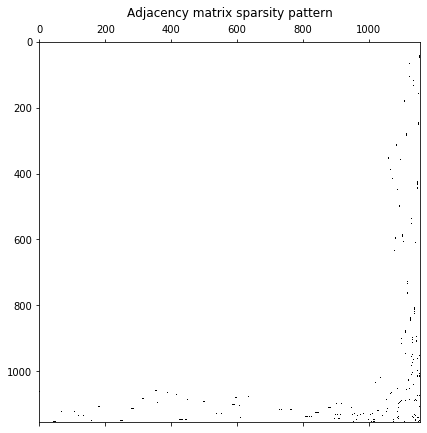

In [22]:
plt.figure(figsize=(10,7))
plt.title('Adjacency matrix sparsity pattern')
plt.spy(reduced_A)
plt.show()

We can see here that, as expected, removing hubs from our network makes the adjacency matrix even more sparser than it already was.

In [23]:
# study of the new moments
degrees = np.sum(reduced_A, axis=0).reshape(-1)
print("The first moment of this graph is", np.mean(degrees))
print("The second moment of this graph is", np.mean(np.power(degrees,2)))

The first moment of this graph is 1.8737024221453287
The second moment of this graph is 17.18166089965398


We can observe that removing some hubs from our network only slightly influences the first two moments of the degree distribution. That means that hubs does not capture a big part of the degree distribution. And as the adjacency matrix is already very sparse, it might not be useful to remove hubs here.

Below, you will find a log-log normalized histogram of the degree distribution for both our network and our network with hubs removed. Note that we will come back on degree distribution when we try to identify the type of our graph in [Part III](#Part-III:-Type-of-graph-identification).

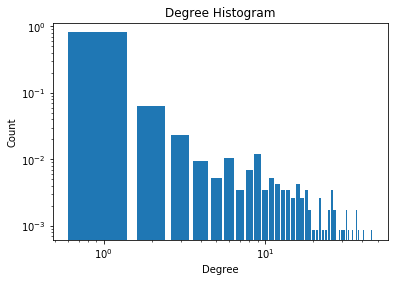

In [51]:
# normalized histogram of the original network
hist = np.array(nx.degree_histogram(G))
normalized_hist = hist/degrees.shape[0]
plt.bar(range(1,len(hist)),normalized_hist[1:])
plt.yscale("log")
plt.xscale("log")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

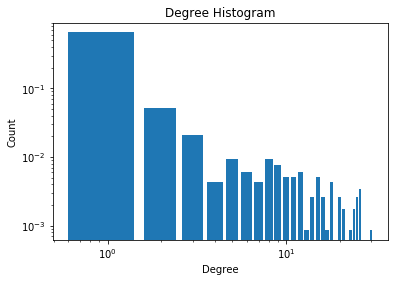

In [52]:
# normalized histogram of the network without some of its hubs
hist = np.array(nx.degree_histogram(G_reduced))
normalized_hist = hist/degrees.shape[0]
plt.bar(range(1,len(hist)),normalized_hist[1:])
plt.yscale("log")
plt.xscale("log")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

Plotting normalized histograms of both networks confirm that removing hubs does not change a lot the properties of the graph, as the degree distribution only changes slightly.

### 3) clusters

In [44]:
# study of clustering metrics in our graph
nb_triangles = nx.triangles(G)
transitivity = nx.transitivity(G)
print("Our graph has an average number of triangles of", 
      np.mean(list(nb_triangles.values())),
      "and a transitivity of", np.round(transitivity,4))

Our graph has an average number of triangles of 0.5608919382504288 and a transitivity of 0.0394


The triangles method from networkx returns the number of triangles that contain a node as one vertex, and this for each node. Here we can see that the mean of the number of triangles of all nodes is quite low (less than one triangle for each node in average). The transitivity is another great metric to get the fraction of all possible triangles in G, and here it is quite small. That means that in our graph we do not have a high number of triangles compared to what it is possible to have at most.

## Part III: Type of graph identification

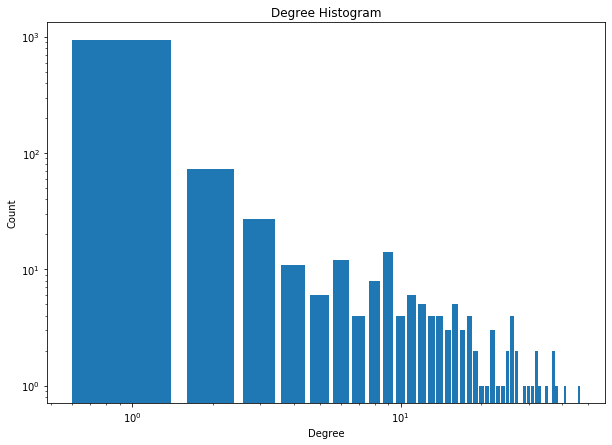

In [50]:
# log-log histogram of the degree distribution
frequencies = nx.degree_histogram(G)
plt.figure(figsize=(10,7))
plt.bar(range(1,len(frequencies)), frequencies[1:])
plt.title("Degree Histogram - Log/Log plot")
plt.xscale('log')
plt.yscale('log')
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

Looking at the log-log histogram, we can notice that the degree distribution seems to follow a power law, because of the linear decay in the log scale. Indeed, the tail is quite heavy, which means that some nodes are highly connected compared to other nodes.

In order to confirm our intuition, we can try to find a graph with a degree distribution that follows a powerlaw and is close to our graph.

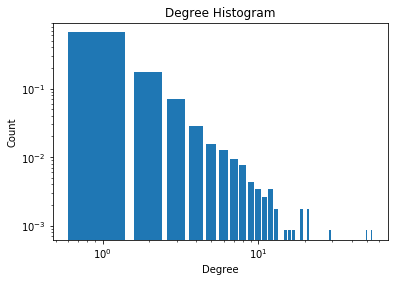

This graph has 1166 nodes and 1165 edges.


In [48]:
# trying to find this close graph
better_fit_graph = nx.powerlaw_cluster_graph(len(G.nodes()), m=1, p=0.001)
hist = np.array(nx.degree_histogram(better_fit_graph))
normalized_hist = hist/degrees.shape[0]
plt.bar(range(1,len(hist)),normalized_hist[1:])
plt.yscale("log")
plt.xscale("log")
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.show()

print("This graph has", len(better_fit_graph.nodes), "nodes and", len(better_fit_graph.edges), "edges.")

We can see that this degree distribution is quite close to what we have above, and therefore that this powerlaw network is quite a good approximation of our own network. That confirms our intuition that network has a degree distribution that follows a powerlaw.

## Part IV: Node properties

### 1) clustering coefficients

In [46]:
# computation of the average clustering coefficient
print("The Average clustering coefficient for our graph is:", np.round(nx.average_clustering(G), 4))

The Average clustering coefficient for our graph is: 0.0475


In [47]:
# clustering coefficients of the nodes 
clus_coefs = nx.clustering(G)
sorted_clus_coefs = collections.OrderedDict(sorted(clus_coefs.items(), key=operator.itemgetter(1), reverse=True))
print("Top 10 nodes with highest clustering coefficient:")
list(sorted_clus_coefs.items())[:10]

Top 10 nodes with highest clustering coefficient:


[('twitterbot', 1.0),
 ('catastrophic interference', 1.0),
 ('neural gas', 1.0),
 ('comparison of agent-based modeling software', 1.0),
 ('agent-based computational economics', 1.0),
 ('distributed artificial intelligence', 1.0),
 ('digital organism', 1.0),
 ('duck test', 1.0),
 ('cognitive map', 1.0),
 ('neural correlate', 1.0)]

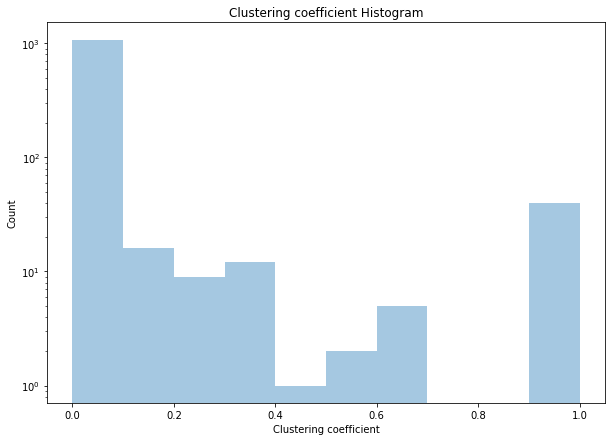

In [49]:
# clustering coefficients distribution
cc_sequence = list(clus_coefs.values())

plt.figure(figsize=(10,7))
sns.distplot(cc_sequence, kde=False, hist_kws={'log':True}, bins=10)
plt.title("Clustering coefficient Histogram")
plt.ylabel("Count")
plt.xlabel("Clustering coefficient")
plt.show()

As we can see on the above plot, we have a considerable number of nodes that have a clustering coefficient of 1, that is, a neighborhood that is fully connected. Otherwise, the majority of the nodes have a clustering coefficient less than 0.4, and that is quite expected regarding how we constructed this network.

### 2) centrality

In [59]:
# study of the centrality of the nodes
cent = nx.degree_centrality(G)
sorted_cent = collections.OrderedDict(sorted(cent.items(), key=operator.itemgetter(1), reverse=True))
print("Top 10 nodes with highest centrality:")
list(sorted_cent.items())[:10]

Top 10 nodes with highest centrality:


[('artificial neural network', 0.03948497854077253),
 ('cognitive science', 0.0351931330472103),
 ('analytics', 0.03261802575107296),
 ('simulated reality', 0.03175965665236051),
 ('universal basic income', 0.03175965665236051),
 ('data analysis', 0.030042918454935622),
 ('semantic web', 0.028326180257510727),
 ('cognitive architecture', 0.027467811158798282),
 ('natural language processing', 0.027467811158798282),
 ('multi-agent system', 0.026609442060085836)]

Centrality is another interesting metric to identify the most important vertices in our network. And as we can see, terms that seems to be the most important are in general central concepts of the pages we chose to generate the network from. On the other hand, as the highest centrality coefficients are quite reasonable, we can confirm that our graph is not only gravitating around a few very important nodes, but more repartited around a considerable number of important contexts, and that is what we would like to have to be able to design an interesting product.

## Part V: Attributes analysis

### 1) on nodes titles

Some communities:
{'fuzzy agent', 'intelligent agent', 'peas', 'era of intelligent agents'}
{'never-ending language learning', 'cognitive architecture comparison', 'bayesian approaches to brain function', 'conceptual space', 'knowledge level', 'unified theory of cognition', 'biologically inspired cognitive architectures', 'cognitive architecture', 'open mind common sense', 'neural correlates of consciousness', 'image schema', 'cognitive computing'}


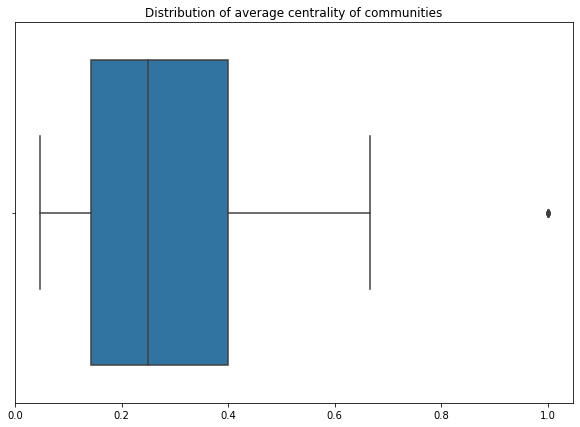

In [24]:
# community detection within the nodes attributes
communities = list(nx.algorithms.community.label_propagation.label_propagation_communities(G))
print("Some communities:")
print(communities[0])
print(communities[1])

# computation of average centrality among communities
avg_cent = []
for com in communities:
    G_tmp = G.subgraph(com)
    cent = nx.degree_centrality(G_tmp)
    avg_cent.append(np.mean(list(cent.values())))
    
# box plot to have a representation of the average centrality among communities
plt.figure(figsize=(10,7))
plt.title("Distribution of average centrality of communities")
sns.boxplot(avg_cent)
plt.show()

By using label propagation algorithm, we have been able to get the communities among the nodes of our network. It is interesting to study communities, as we can check that these communities have members that are related to each other (in terms of topic). Another interesting metric we can study once we have communities is the average centrality among these commmunities. That allow us to confirm that these communities have members that are quite strongly connected with each other, and that these communities were not only formed on a few links between each other. And the above boxplot illustrates that in average, centrality of our communities is quite decent, and that most of the communities have a centrality that stands in a reasonable interval. 

In [164]:
# some basic NLP to study nodes attributes
nodes_emb = list(G.nodes)
print("Some nodes embeddings:")
print(nodes_emb[:10])

# get the list of all the words from the articles titles
nodes_emb_flattened = [word for line in nodes_emb for word in line.split()]

# initialize a dict that counts the words occurences
counts = Counter(nodes_emb_flattened)
print("\nSome entries of the dictionnary that counts the words occurences:")
print(list(counts.items())[:7])

Some nodes embeddings:
['intelligent agent', 'software agent', 'cognitive architecture', 'cognitive radio', 'cybernetics', 'computer science', 'embodied agent', 'federated search', 'fuzzy agent', 'fuzzy logic']

Some entries of the dictionnary that counts the words occurences:
[('intelligent', 5), ('agent', 12), ('software', 18), ('cognitive', 23), ('architecture', 12), ('radio', 3), ('cybernetics', 3)]


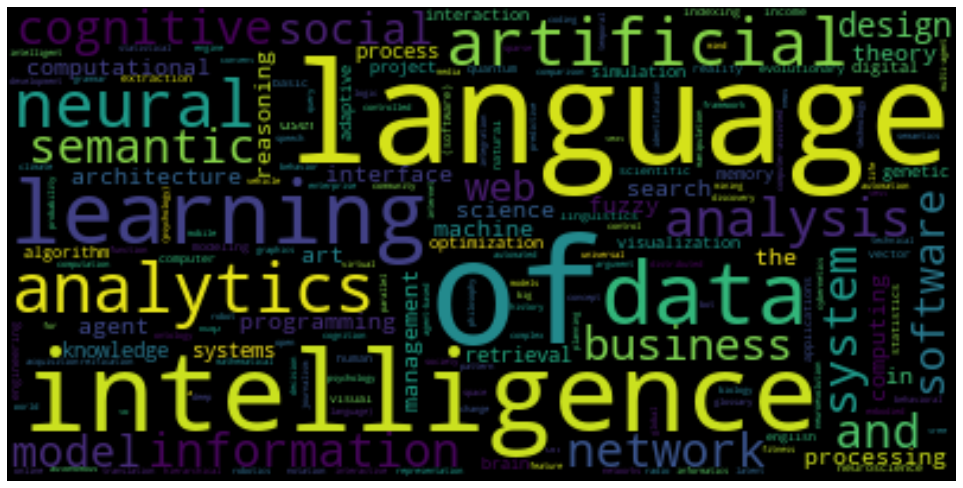

In [166]:
# creation and generation of a word cloud image, which displays words with sizes proportional to their occurences
wordcloud = WordCloud() 
wordcloud.generate_from_frequencies(frequencies=counts)

plt.figure(figsize=(17,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

This fancy worldcloud plot is contructed by using the word occurences among all titles of the pages that form our networm. As as we can see on the above result, terms that are the strongest are hopefully central terms that define the concepts we chose to use to generate our network. For example, we can notice "language", "data", "analytic", "intelligence", or "learning".

### 2) on nodes embeddings (keywords)

In this subpart, we are going to load the keywords that we created for our pages (see Exploitation notebook), and perform an analysis of the words distribution and occurences to see if the important words are related to strong concepts.

In [143]:
df_node = pd.read_csv('df_node.csv', converters={'keywords' : pd.eval}).drop('Unnamed: 0',axis=1)
df_node.head()

,name,url,keywords
0,intelligent agent,https://en.wikipedia.org/wiki/Intelligent_agent,"[intelligent, agents, agent, autonomous, abstr..."
1,chatbot,https://en.wikipedia.org/wiki/Chatbot,"[chatbots, apps, keywords, conversational, pro..."
2,artificial neural network,https://en.wikipedia.org/wiki/Artificial_neura...,"[cats, cat, neurons, images, biological, ann, ..."
3,artificial intelligence,https://en.wikipedia.org/wiki/Artificial_intel...,"[ai, intelligence, machines, humans, considere..."
4,weak ai,https://en.wikipedia.org/wiki/Weak_AI,"[ai, narrow, weak, minds, intelligence, proble..."


In [155]:
# get the list of all the keywords
keywords_list = []
for el in df_node['keywords']:
    for e in el:
        keywords_list.append(e)

# initialize a dict that counts the words occurences
counts = Counter(keywords_list)

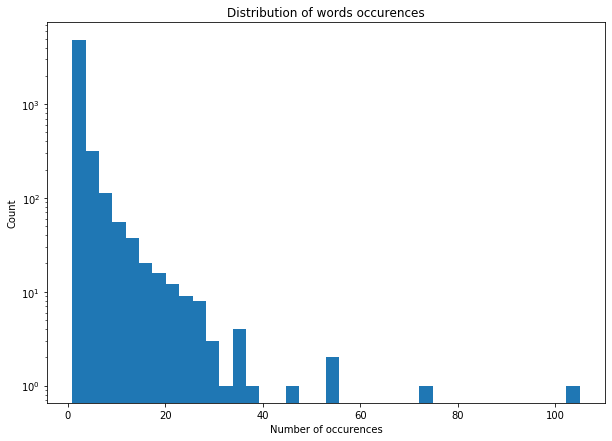

In [156]:
N = len(np.unique(list(counts.values())))
fig = plt.figure(figsize=(10,7))
plt.hist(list(counts.values()), bins=N)
plt.yscale("log")
plt.title("Distribution of words occurences")
plt.ylabel("Count")
plt.xlabel("Number of occurences")
plt.show()

As we can see on the above histogram, most of the words appear once, and we have some words that are very frequent as well. Let's see which words are the most frequent.

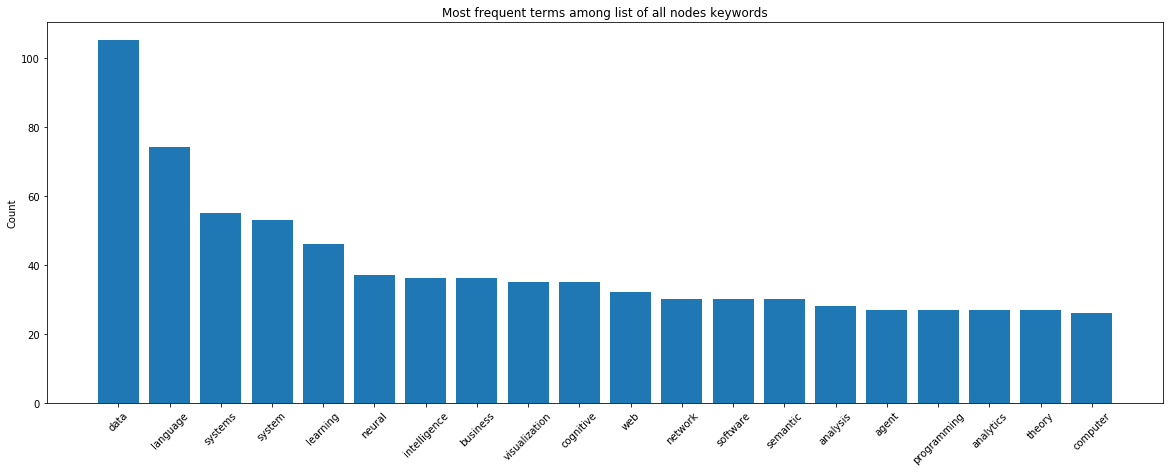

In [157]:
most_common = counts.most_common(20)
xaxis = [g for g,x in most_common]
yaxis = [x for g,x, in most_common]

fig, ax = plt.subplots(figsize=(20,7))
ax.bar(np.arange(1,len(yaxis)+1,1), yaxis)
ax.set_xticks(np.arange(1,len(yaxis)+1,1))
ax.set_xticklabels(xaxis, rotation=45)
ax.set_title('Most frequent terms among list of all nodes keywords')
ax.set_ylabel('Count')
plt.show()

As we can see here, the most frequent words are strong concepts that are highly related with the seeds we chose to use to generate our graph. Below, you can find a more visual representation of the strong words that are present in the list of the keywords of all the nodes.

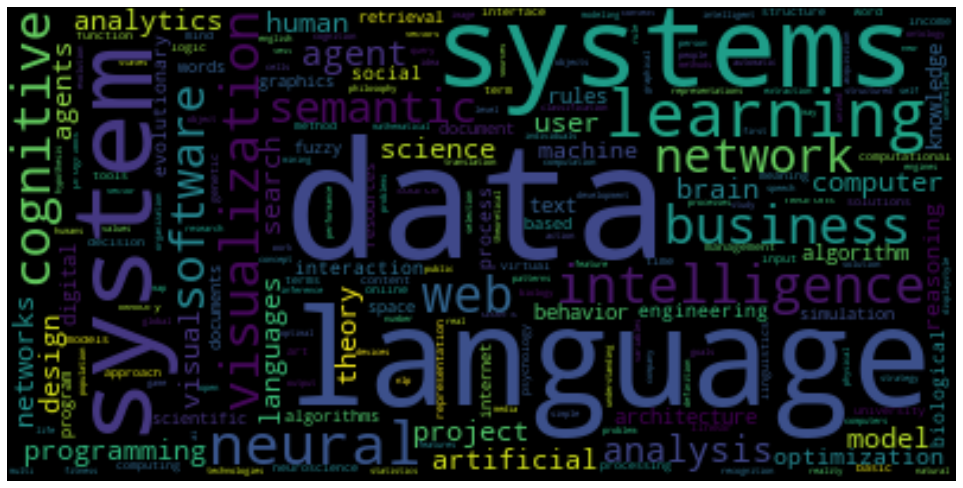

In [163]:
# again, creation and generation of a word cloud image
wordcloud = WordCloud() 
wordcloud.generate_from_frequencies(frequencies=counts)

plt.figure(figsize=(17,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()